In [ ]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt, cm
from PIL import Image

In [36]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
#load data
# data = []
for folder in os.listdir('./photos'):
    folder_path = os.path.join('./photos', folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        for file in os.listdir(folder_path):
            try:
                species = file.split('_')[0]
                # Use regex to extract the number part
                match = re.search(r'_(\d+)', file)
                if match:
                    growth_stage_num = int(match.group(1))
                    if growth_stage_num == 10:
                        growth_stage = 'early'
                    elif growth_stage_num in [11, 12]:
                        growth_stage = 'middle'
                    else:
                        growth_stage = 'late'
                    data.append([os.path.join(folder_path, file), f'{species} {growth_stage}'])
            except ValueError:
                # Skip files that don't match the expected format
                continue

In [4]:
# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['image_path', 'species'])

In [5]:
species_counts = df['species'].value_counts()

print(species_counts)

species
LAMPU early     60
POLLA early     60
CHEAL early     60
LAMPU middle    30
LAMPU late      30
POLLA middle    30
POLLA late      30
CHEAL late      30
CHEAL middle    30
Name: count, dtype: int64


In [6]:
df

,image_path,species
0,./photos/LAMPU120/LAMPU_10 (22).jpg,LAMPU early
1,./photos/LAMPU120/LAMPU_12_03 (2).jpg,LAMPU middle
2,./photos/LAMPU120/LAMPU_10 (34).jpg,LAMPU early
3,./photos/LAMPU120/LAMPU_12_02 (3).jpg,LAMPU middle
4,./photos/LAMPU120/LAMPU_10 (18).jpg,LAMPU early
...,...,...
355,./photos/CHEAL120/CHEAL_10_23 (2).jpg,CHEAL early
356,./photos/CHEAL120/CHEAL_11_04.jpg,CHEAL middle
357,./photos/CHEAL120/CHEAL_10_44.jpg,CHEAL early
358,./photos/CHEAL120/CHEAL_14_08.jpg,CHEAL late


CNN

In [7]:
# Extract species (labels) and image paths
species = df['species']
image_paths = df['image_path']

In [8]:
# Encode species into numerical labels
species_labels = species.astype('category').cat.codes
num_classes = species_labels.nunique()

In [9]:
# Ensure 'species' is a categorical type
species = df['species'].astype('category')

# Encode species into numerical labels
species_labels = species.cat.codes
num_classes = species_labels.nunique()

In [10]:
# Create a mapping from species to numerical labels
species_to_label = dict(zip(species.cat.categories, range(len(species.cat.categories))))

# Print out the mapping
print("Species to Numerical Label Mapping:")
for species_name, label in species_to_label.items():
    print(f"{species_name}: {label}")

# Print number of classes
print(f"Number of Classes: {num_classes}")

Species to Numerical Label Mapping:
CHEAL early: 0
CHEAL late: 1
CHEAL middle: 2
LAMPU early: 3
LAMPU late: 4
LAMPU middle: 5
POLLA early: 6
POLLA late: 7
POLLA middle: 8
Number of Classes: 9


In [11]:
# Function to load and preprocess images
def load_images(paths, target_size=(128, 128)):
    images = []
    for path in paths:
        img = Image.open(path).resize(target_size).convert('RGB')
        images.append(np.array(img) / 255.0)  # Normalize images
    return np.array(images)

In [12]:
# Load images
images = load_images(image_paths)

In [13]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, species_labels, test_size=0.2, random_state=42, stratify=species_labels)

In [129]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [15]:
# Check class distribution in the original dataset
original_class_distribution = species_labels.value_counts()
print("Class Distribution in Original Dataset:")
print(original_class_distribution)

Class Distribution in Original Dataset:
3    60
6    60
0    60
5    30
4    30
8    30
7    30
1    30
2    30
Name: count, dtype: int64


In [16]:
# Convert the one-hot encoded labels to class indices
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Convert to pandas Series
y_train_series = pd.Series(y_train_indices)
y_test_series = pd.Series(y_test_indices)

# Check class distribution in the training set
train_class_distribution = y_train_series.value_counts()
print("Class Distribution in Training Set:")
print(train_class_distribution)

# Check class distribution in the test set
test_class_distribution = y_test_series.value_counts()
print("Class Distribution in Test Set:")
print(test_class_distribution)

Class Distribution in Training Set:
6    48
0    48
3    48
5    24
4    24
7    24
2    24
8    24
1    24
Name: count, dtype: int64
Class Distribution in Test Set:
3    12
6    12
0    12
2     6
5     6
1     6
8     6
7     6
4     6
Name: count, dtype: int64


In [104]:
# Define the CNN model
initializer = tf.keras.initializers.GlorotUniform(seed=seed)
input_layer = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=initializer)(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=initializer)(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializer)(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten(name='flatten')(x)
x = Dense(128, activation='relu', kernel_initializer=initializer)(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax', kernel_initializer=initializer)(x)

In [105]:
model = Model(inputs=input_layer, outputs=output_layer)

In [106]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
# Build the model by calling it with some input data
dummy_input = np.zeros((1, 128, 128, 3))
_ = model.predict(dummy_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [114]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Set random seed in the data generator for reproducibility
datagen.seed = seed

In [115]:
# Compile the model with a lower learning rate
from tensorflow.keras.optimizers import Adam

learning_rate = 0.00075  # Decreased from default 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [116]:
# Fit the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=20
)

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.6652 - loss: 0.9787 - val_accuracy: 0.6528 - val_loss: 0.8786
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6879 - loss: 0.8598 - val_accuracy: 0.6806 - val_loss: 0.8513
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.7237 - loss: 0.7840 - val_accuracy: 0.5833 - val_loss: 1.0481
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.7057 - loss: 0.7663 - val_accuracy: 0.6667 - val_loss: 0.8349
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7270 - loss: 0.7516 - val_accuracy: 0.6389 - val_loss: 0.9322
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6810 - loss: 0.7758 - val_accuracy: 0.6806 - val_loss: 0.8307
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7133 - loss: 0.7483 - val_accuracy: 0.6667 - val_loss: 0.7999
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.7206 - loss: 0.6855 - val_accuracy: 0.6944 - val_loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6675 - loss: 0.8601
Test Accuracy: 0.69


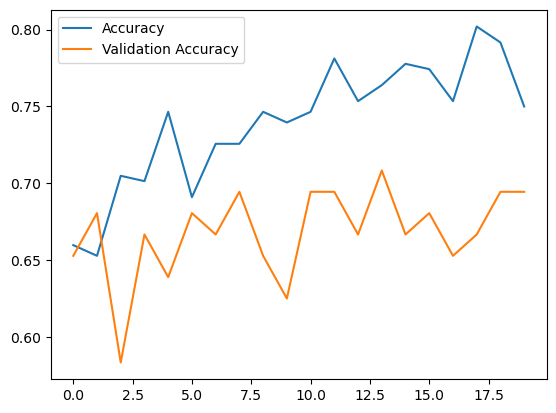

In [117]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [119]:
# Get predicted labels
y_pred_probs = model.predict(X_test)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class indices
y_true = np.argmax(y_test, axis=1)  # True class indices

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [120]:
# Ensure 'species' is a categorical variable
species = pd.Categorical(species)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


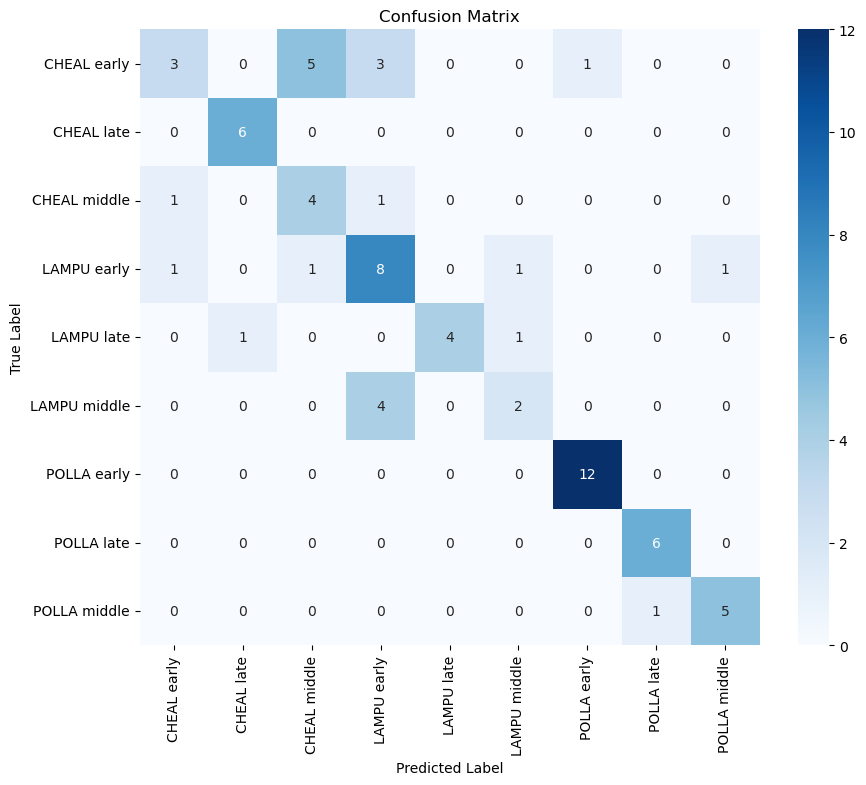

In [121]:
# Step 1: Predict on the test set
y_pred_prob = model.predict(X_test)  # Assuming you have `model` trained already

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Step 2: Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_indices, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=species.categories, yticklabels=species.categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [122]:
# Save species names before encoding
species_categories = species.unique()

# Print classification report with correct labels
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=species_categories))

Classification Report:
              precision    recall  f1-score   support

 LAMPU early       0.60      0.25      0.35        12
LAMPU middle       0.86      1.00      0.92         6
  LAMPU late       0.40      0.67      0.50         6
POLLA middle       0.50      0.67      0.57        12
 POLLA early       1.00      0.67      0.80         6
  POLLA late       0.50      0.33      0.40         6
  CHEAL late       0.92      1.00      0.96        12
 CHEAL early       0.86      1.00      0.92         6
CHEAL middle       0.83      0.83      0.83         6

    accuracy                           0.69        72
   macro avg       0.72      0.71      0.70        72
weighted avg       0.71      0.69      0.68        72



PCA after CNN

In [123]:
# Define the mapping from numerical labels to class names
label_mapping = {
    0: 'CHEAL early',
    1: 'CHEAL late',
    2: 'CHEAL middle',
    3: 'LAMPU early',
    4: 'LAMPU late',
    5: 'LAMPU middle',
    6: 'POLLA early',
    7: 'POLLA late',
    8: 'POLLA middle'
}

In [124]:
# Extract features from the Flatten layer
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('flatten').output)
features = feature_extractor.predict(X_train)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [125]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(features)

In [126]:
# Define the unique classes
unique_classes = np.unique(np.argmax(y_train, axis=1))
num_classes = len(unique_classes)

In [127]:
# Create a color map
colors = cm.rainbow(np.linspace(0, 1, num_classes))

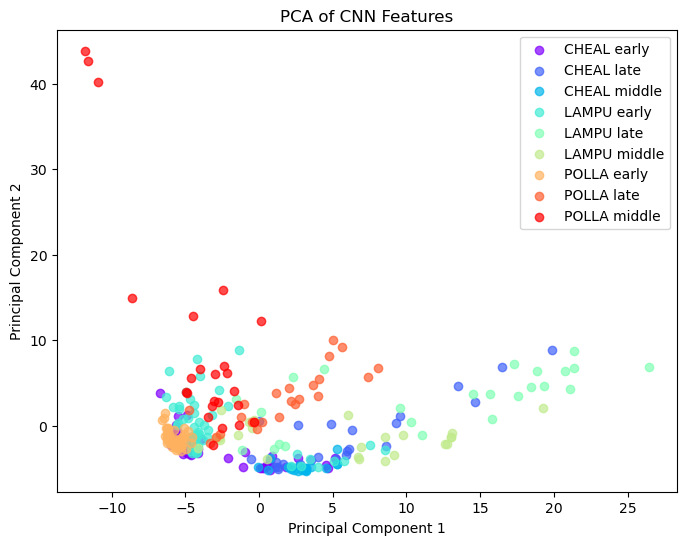

In [128]:
# Plot each class with a distinct color
plt.figure(figsize=(8, 6))
for i, cls in enumerate(unique_classes):
    idx = np.argmax(y_train, axis=1) == cls
    plt.scatter(
        principal_components[idx, 0], 
        principal_components[idx, 1], 
        color=colors[i], 
        label=label_mapping[cls],  # Use the class names
        alpha=0.7
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of CNN Features')
plt.legend()
plt.show()